<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics

<img style="float: left;" src="colored-bar.png"/>

### This notebook provides code that allows comparaison of LIDAR Canopy Height Model tree height estimates to insitu tree height measurements.

### Study locations are the low elevation [NEON SJER](https://www.neonscience.org/field-sites/sjer) study area in California and the mid-elevation [NEON SOAP](https://www.neonscience.org/field-sites/soap) study area in California.

Users of this notebook:   1)  A sample data set from [EarthPy](https://earthpy.readthedocs.io/en/latest/earthpy-data-subsets.html) is downloaded to your local machine.  2)  Change the study_site variable to either sjer or soap study sites.

Code by Tyler Cruickshank (tcruicks@gmail.com)
[GitHub](https://github.com/tcruicks)

![Colored Bar](colored-bar.png)

In [129]:
import os
import pathlib

import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterstats as rs
import seaborn as sns


![Colored Bar](colored-bar.png)
### Set Project Plotting styles.
![Colored Bar](colored-bar.png)

In [130]:
# Set consistent plotting style for all code cells.
sns.set_style("white")
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')


![Colored Bar](colored-bar.png)
### Setup Paths for project. Change study_site variable.
![Colored Bar](colored-bar.png)

In [131]:
# Set up paths, directories, and study site name variable for the project.

study_site = 'soap'

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)

base_dir = os.path.join(
    'california',
    "neon-{}-site".format(study_site),
)

os.chdir(home_dir)

# Create an output dir for created files.
output_path = os.path.join(home_dir, 'outputs')
if not os.path.isdir(output_path):
    os.makedir(output_path)

# ----------------------------------

# Ground based measurements.
if (study_site == 'sjer'):
    insitu_path = os.path.join(
        base_dir,
        '2013',
        'insitu',
        'veg_structure',
        "D17_2013_{}_vegStr.csv".format(study_site.upper()),
    )
elif (study_site == 'soap'):
    insitu_path = os.path.join(
        base_dir,
        '2013',
        'insitu',
        'veg-structure',
        "D17_2013_{}_vegStr.csv".format(study_site.upper()),
    )

# Lidar Canopy Height Model
lidar_chm_path = os.path.join(
    base_dir,
    '2013',
    'lidar',
    "{}_lidarCHM.tif".format(study_site),
)

if (study_site == 'sjer'):
    plots_path = os.path.join(
        base_dir,
        'vector_data',
        "{}_plot_centroids.shp".format(study_site)
    )
elif (study_site == 'soap'):
    plots_path = os.path.join(
        base_dir,
        'vector_data',
        "{}_centroids.shp".format(study_site)
    )


![Colored Bar](colored-bar.png)
### Download Dataset.
![Colored Bar](colored-bar.png)

In [132]:
# Download the dataset that contains everything needed for the project
# from EarthPy.

# Getting the list of directories
dir = os.listdir(home_dir)

# Checking if the list is empty or not
if len(dir) == 0:
    et.data.get_data('spatial-vector-lidar')
else:
    print("SJER LIDAR DATA EXISTS.")


SJER LIDAR DATA EXISTS.


![Colored Bar](colored-bar.png)
### Functions.
![Colored Bar](colored-bar.png)

In [133]:
def plot_data(lidar, points, study_site):
    """ 
    Creates a quick plot given a raster image and point file.

    Parameters:
    ----------
    lidar: datarray
        A datarray - Landsat in this case.
    points: geodataframe
        A geodatframe containing point locations

    Returns:
    -------
    A plot to screen.

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    lidar.plot(ax=ax)
    points.plot(ax=ax, marker='s', markersize=200, color='red')

    # Capitalize study_site for title.
    title = "{} Study Site:  LIDAR CHM and Study Sites".format(
        study_site.upper())
    ax.set_title(title)

    plt.show()


In [134]:
def create_buffered_plots(plots_path, buf_size):
    """ 
    Creates buffers around study plot locations.
    Parameters:
    ----------
    plots_path: str
        Path to the study plot centroids shape file.
    buf_size: int
        Size (m) of the buffer to calculate.
    Returns:
    -------
    plots_gdf: geodataframe
        A geodataframe of plot buffer geometry.
    plot_buffer_path:
        A path to the buffer shapefile.
    """
    # Open sjer plot location file.
    plots_gdf = gpd.read_file(plots_path)
    # reset the geometry to the buffer version.
    plots_gdf.geometry = plots_gdf.geometry.buffer(buf_size)
    plots_gdf.head()

    # Name and location of the buffered insitu measurement sites.
    plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")
    # Create the buffered file.
    plots_gdf.to_file(plot_buffer_path)

    return (plots_gdf, plot_buffer_path)


In [135]:
def calculate_lidar_zonal_stats(plot_buffer_path, lidar_chm_clean, stats):
    """ 
    Calculates statistics from the lidar file and plot location buffers.
    Parameters:
    ----------
    plot_buffer_path: str
        A path to the plot_buffer.shp file.
    lidar_chm_clean: dataarray
        Cleaned up lidar file.
    stats: list
        List of stats to be calculated.
    Returns:
    -------
    lidar_chm_stats_gdf: geodataframe
        A gdf with the zonal stats for each plot.

    """
    lidar_chm_stats = rs.zonal_stats(
        plot_buffer_path,
        lidar_chm_clean.values,
        stats=['mean', 'max'],
        affine=lidar_chm_clean.rio.transform(),
        geojson_out=True, nodata=0, copy_properties=True,
    )
    # Stick it in a dataframe.
    lidar_chm_stats_gdf = gpd.GeoDataFrame.from_features(lidar_chm_stats)

    # Rename df columns.
    lidar_chm_stats_gdf.rename(
        columns={'max': 'lidar_max', 'mean': 'lidar_mean', 'ID': 'Plot_ID'},
        inplace=True
    )
    return (lidar_chm_stats_gdf)


In [147]:
def calculate_insitu_stats(insitu_path):
    """ 
    Open, process insitu file and calculate stats from insitu measurements.
    Parameters:
    ----------
    insitu_path: str
        Path tho the insitu measurements .csv file..
    Return:
    ------
    insitu_stem_height_df: dataframe
        Dataframe of the insitu measurement stats.

    """
    insitu_gdf = gpd.read_file(insitu_path)

    # Reduce the columns to only what we need.
    insitu_gdf = (insitu_gdf[
        ["siteid", "sitename", "plotid", "stemheight", "scientificname"]])

    # This solves an oddity.  The 'stemheight' column is not coming out as numeric.
    # We need to change the datatype to a float.  As a float .mean and .max will work.
    insitu_gdf["stemheight"] = pd.to_numeric(
        insitu_gdf["stemheight"], downcast="float")

    # ------------ Create new df of insitu stem height and stats. ---------------- #
    # Create a df to include max and mean height.
    insitu_stem_height_df = (insitu_gdf.groupby(
        'plotid')['stemheight'].agg(['max', 'mean']))

    # Rename column names to be more explanatory/
    insitu_stem_height_df.rename(
        columns={"mean": "insitu_mean", "max": "insitu_max"},
        inplace=True
    )

    # The index is plotid but we just want 0 ... 9 ...
    insitu_stem_height_df = insitu_stem_height_df.reset_index()
    insitu_stem_height_df.head()

    return (insitu_stem_height_df)


In [148]:
def create_comparison_plots(all_heights_gdf, max_range):
    """ 
    Create two plots of lidar vs insitu : MAx and Mean tree heights.
    Parameters:
    ----------
    all_heights_gdf: geodataframe
        Geodataframe holding merged lidar and insitu stats.

    """
    # Why do I need to convert from a gdf to a df in order to plot?
    all_heights_gdf = pd.DataFrame(all_heights_gdf)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")

    all_heights_gdf.plot('lidar_max',
                         'insitu_max',
                         kind='scatter',
                         fontsize=14, s=20,
                         color="purple",
                         ax=ax1
                         )

    all_heights_gdf.plot('lidar_mean',
                         'insitu_mean',
                         kind='scatter',
                         fontsize=14, s=20,
                         color="purple",
                         ax=ax2
                         )

    ax1.set(xlim=max_range, ylim=max_range)
    ax1.set_aspect('equal')
    ax2.set(xlim=[0, 30], ylim=[0, 30])

    # Add 1:1 lines ---------
    ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
    ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')

    sns.regplot(x='lidar_max', y='insitu_max',
                data=all_heights_gdf, color="purple", ax=ax1)
    sns.regplot(x='lidar_mean', y='insitu_mean',
                data=all_heights_gdf, color="purple", ax=ax2)

    title1 = "Tree Heights: Lidar Calculated vs. Manual Measurement\n"
    title2 = "{} Study Plot\n".format(study_site.upper())
    title3 = "Max Height, Mean Height"
    title = title1 + title2 + title3

    fig.suptitle(title, size='medium')

    plt.show()


![Colored Bar](colored-bar.png)
### The Main ...
![Colored Bar](colored-bar.png)

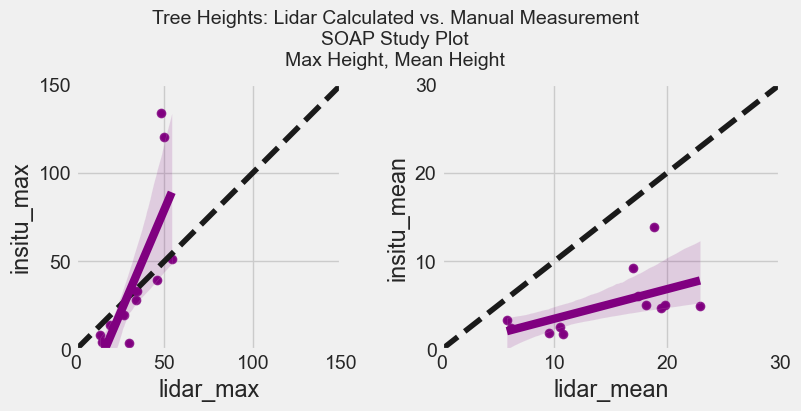

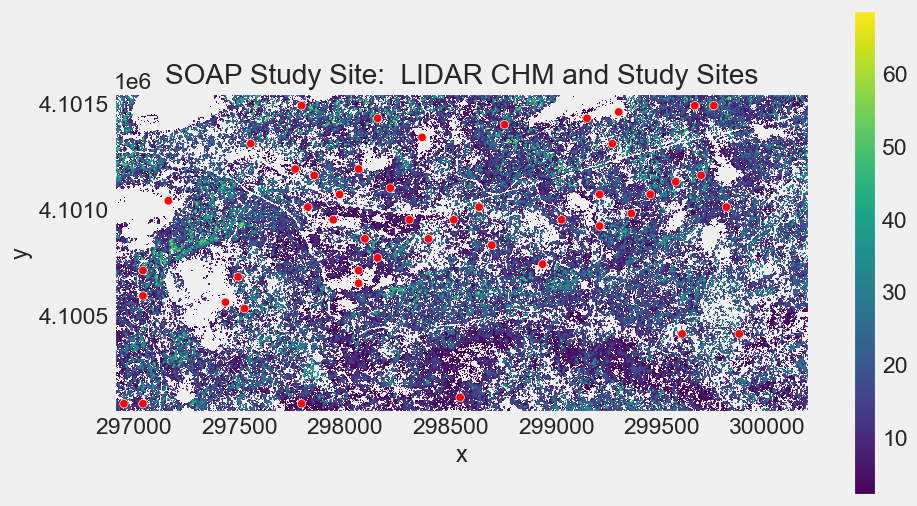

In [149]:
# MAIN Code Cell -----

# ----------- OPEN and PROCESS LIDAR CHM ------------------------ #
lidar_chm = rxr.open_rasterio(lidar_chm_path, masked=True).squeeze()
# Clean up the lidar file.
lidar_chm_clean = lidar_chm.where(lidar_chm > 0, np.nan)

plots_gdf, plot_buffer_path = create_buffered_plots(plots_path, 20)
lidar_chm_stats_gdf = calculate_lidar_zonal_stats(
    plot_buffer_path, lidar_chm_clean, ['Max', 'Mean'])
insitu_stem_height_df = calculate_insitu_stats(insitu_path)


# -------------- MERGE Insitu stats df with LIDAR stats df ---------------- #
# The SOAP columns dont quite match.  The Lidar file column needs 'SOAP' appended.
if (study_site == 'soap'):
    ss = study_site.upper()
    lidar_chm_stats_gdf['Plot_ID'] = ss + lidar_chm_stats_gdf['Plot_ID']

all_heights_gdf = lidar_chm_stats_gdf.merge(
    insitu_stem_height_df,
    left_on='Plot_ID',
    right_on='plotid')

max_range = [0, 150]
create_comparison_plots(all_heights_gdf, max_range)

# Quick plot of lidar and plot locations.
plot_data(lidar_chm_clean, plots_gdf, study_site)
